Kafka is used to send messages containing Viapass data

You need to have Kafka and Zookeeper servers running to execute this notebook. If you use the Docker container, these servers should already be running. Otherwise, you may start them on your machine with

```
nohup $KAFKA_PATH/bin/zookeeper-server-start.sh $KAFKA_PATH/config/zookeeper.properties  > $HOME/zookeeper.log 2>&1 &
nohup $KAFKA_PATH/bin/kafka-server-start.sh $KAFKA_PATH/config/server.properties > $HOME/kafka.log 2>&1 &
```

where KAFKA_PATH points to the folder containing Kafka. See https://kafka.apache.org/quickstart for how to install Kafka on your machine.

In [1]:
import requests
import time
import json
import os   
import logging
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry import shape
from shapely.geometry import Point, Polygon
from fiona.crs import from_epsg
from kafka import KafkaProducer




## Retrieve data from Viapass CSV file

In [2]:
obu_columns=['unique_id','truck_id','longitude','latitude',\
             'datetime','velocity','direction','countrycode','eurovalue','mtm',\
            'date','time','retrieved_time','geometry','index_commune','region','commune','index_right']

locations_df =pd.read_csv("data_week.csv",names=obu_columns).drop(['index_right'], axis = 1) 

locations_df = locations_df.sort_values(by=['retrieved_time'])

locations_df.head()

,unique_id,truck_id,longitude,latitude,datetime,velocity,direction,countrycode,eurovalue,mtm,date,time,retrieved_time,geometry,index_commune,region,commune
69105,2513665447_2018-09-23T02:58:22,2513665447,4.281629,50.82138,2018-09-23 02:58:22.000000,84,147,BE,5,1199,2018-09-23,02:58:22,2018-09-23 03:03:14.521033,POINT (4.281629 50.82138),11.0,BCR,Anderlecht
69106,2513665447_2018-09-23T02:58:22,2513665447,4.281629,50.82138,2018-09-23 02:58:22.000000,84,147,BE,5,1199,2018-09-23,02:58:22,2018-09-23 03:03:35.432470,POINT (4.281629 50.82138),11.0,BCR,Anderlecht
69107,2513665447_2018-09-23T02:58:22,2513665447,4.281629,50.82138,2018-09-23 02:58:22.000000,84,147,BE,5,1199,2018-09-23,02:58:22,2018-09-23 03:03:56.452375,POINT (4.281629 50.82138),11.0,BCR,Anderlecht
69108,2513665447_2018-09-23T02:58:22,2513665447,4.281629,50.82138,2018-09-23 02:58:22.000000,84,147,BE,5,1199,2018-09-23,02:58:22,2018-09-23 03:04:17.879058,POINT (4.281629 50.82138),11.0,BCR,Anderlecht
69109,2513665447_2018-09-23T02:58:22,2513665447,4.281629,50.82138,2018-09-23 02:58:22.000000,84,147,BE,5,1199,2018-09-23,02:58:22,2018-09-23 03:04:38.813398,POINT (4.281629 50.82138),11.0,BCR,Anderlecht


In [3]:
#Needed to make time comparisons
locations_df['retrieved_time']=pd.to_datetime(locations_df['retrieved_time'])
locations_df['datetime']=pd.to_datetime(locations_df['datetime'])
locations_df['datetime'].dt.date.unique()

array([datetime.date(2018, 9, 23), datetime.date(2018, 9, 24),
       datetime.date(2018, 9, 25), datetime.date(2018, 9, 26),
       datetime.date(2018, 9, 27), datetime.date(2018, 9, 28),
       datetime.date(2018, 9, 29), datetime.date(2018, 9, 30),
       datetime.date(2018, 10, 1), datetime.date(2018, 10, 2),
       datetime.date(2018, 10, 3), datetime.date(2018, 10, 4),
       datetime.date(2018, 10, 5), datetime.date(2018, 10, 6),
       datetime.date(2018, 10, 7), datetime.date(2018, 10, 8),
       datetime.date(2018, 10, 9), datetime.date(2018, 10, 10),
       datetime.date(2018, 10, 11), datetime.date(2018, 10, 12),
       datetime.date(2018, 10, 13), datetime.date(2018, 10, 14),
       datetime.date(2018, 10, 15), datetime.date(2018, 10, 16),
       datetime.date(2018, 10, 17), datetime.date(2018, 10, 18),
       datetime.date(2018, 10, 19), datetime.date(2018, 10, 20),
       datetime.date(2018, 10, 21), datetime.date(2018, 10, 22)],
      dtype=object)

In [4]:
locations_df = locations_df.sort_values(by='datetime', ascending=False)


In [5]:
# KAFKA PRODUCER

producer = KafkaProducer(bootstrap_servers='localhost:9092')
retrieved_time_start=locations_df.retrieved_time.min()+timedelta(minutes = 2)
street_segments=gpd.read_file('1000m_three_streets.geojson')

In [6]:
# three streets 
street_segments_one = gpd.GeoDataFrame(street_segments.iloc[2]).T
street_segments

,geometry
0,"POLYGON ((4.279965979374574 50.82704383830234,..."
1,"POLYGON ((4.284120643446468 50.81983027843969,..."
2,"POLYGON ((4.272622340160408 50.81986923677554,..."


## Connection to Kafka

In [12]:
batch_interval=10

data_collection_frequency= 60
print('Batch Interavl '+str(data_collection_frequency))

retrieved_time_start=locations_df.retrieved_time.min()

cpt=1

delay_max = []
retrieve = []
number = []

while cpt==1:
    
    #cpt=cpt +1
    starttime=time.time()

    data_chunck=locations_df[(locations_df.retrieved_time>=retrieved_time_start) &\
                          (locations_df.retrieved_time<(retrieved_time_start + timedelta(minutes = data_collection_frequency)))]
    

    print("")
    print("Received time: "+str(retrieved_time_start))
    print("Number of records: "+str(data_chunck.shape[0]))
    
    
    if data_chunck.shape[0]!=0:
    
        #Add street segments IDs
        data_chunck['geometry'] = data_chunck.apply(lambda z: Point( z.longitude, z.latitude,), axis=1)
        #data_chunck['geometry'] = data_chunck.apply(lambda z: Point(  z.latitude,z.longitude), axis=1)

        PointsGeodataframe = gpd.GeoDataFrame(data_chunck)
        PointsGeodataframe.crs = street_segments.crs
        merged=sjoin(PointsGeodataframe, street_segments, how='left', op='within')
        data_chunck=merged[merged.index_right>=0].reset_index(drop=True)
    
    print(data_chunck.shape)
    
    data_chunck['current_time']=pd.to_datetime([retrieved_time_start]* len(data_chunck))+timedelta(minutes = data_collection_frequency)
    
    
    if data_chunck.shape[0] >1:
        delay = []
        for i in range(data_chunck.shape[0]):
            retard = data_chunck.loc[i].retrieved_time - data_chunck.loc[i].datetime
            retard_seconds = retard.total_seconds()
            delay.append(retard_seconds)
            
        maxime = max(delay)
        delay_max.append(maxime)
        retrieve.append(retrieved_time_start.hour)
        number.append(data_chunck.shape[0])
        print('')
        day = maxime // (24 * 3600)
        maxime = maxime % (24 * 3600)
        hour = maxime // 3600
        maxime %= 3600
        minutes = maxime // 60
        maxime %= 60
        seconds = maxime
        print("Delay: %d day,  %d hour, %d minutes, %d seconds" % (day, hour, minutes, seconds))
        print('')
    
    data_chunck = data_chunck.astype(str)
    
    time_preprocess=time.time() - starttime
    print("Time to preprocess: "+str(time_preprocess))
    
    #********** Send to Kafka **********
                
    starttime_send_kafka=time.time()
    
 
    for i in range(data_chunck.shape[0]):

        data=data_chunck.loc[i]
        message=str(list(data))
        print(message)
        producer.send('dataViapass', message.encode())  
    
    producer.flush()
    time_send_kafka=time.time() - starttime_send_kafka
    
    print("Time to send to Kafka: "+str(time_send_kafka))
                    
    #********** End send to kafka **********
    
    retrieved_time_start=retrieved_time_start+timedelta(minutes = data_collection_frequency)
    
    total_time=time.time() - starttime
    print("Time for preprocessing and seding was: "+str(total_time)+"; Waiting "+str(batch_interval-total_time)+" seconds to be synchronized with the receving side")
    
    time.sleep(batch_interval)

Batch Interavl 60

Received time: 2018-09-23 03:03:14.521033
Number of records: 22
(22, 18)

Delay: 0 day,  0 hour, 7 minutes, 15 seconds

Time to preprocess: 0.07775163650512695
['1150616939_2018-09-23T03:35:50', '1150616939', '4.281588', '50.82142', '2018-09-23 03:35:50.000000', '78', '147', 'BE', '5', '6000', '2018-09-23', '03:35:50', '2018-09-23 03:41:01.307435', 'POINT (4.281588 50.82142)', '11.0', 'BCR', 'Anderlecht', '2', '2018-09-23 04:03:14.521033']
['1150616939_2018-09-23T03:35:50', '1150616939', '4.281588', '50.82142', '2018-09-23 03:35:50.000000', '78', '147', 'BE', '5', '6000', '2018-09-23', '03:35:50', '2018-09-23 03:40:40.362433', 'POINT (4.281588 50.82142)', '11.0', 'BCR', 'Anderlecht', '2', '2018-09-23 04:03:14.521033']
['1150616939_2018-09-23T03:35:50', '1150616939', '4.281588', '50.82142', '2018-09-23 03:35:50.000000', '78', '147', 'BE', '5', '6000', '2018-09-23', '03:35:50', '2018-09-23 03:40:19.603262', 'POINT (4.281588 50.82142)', '11.0', 'BCR', 'Anderlecht', '2',

/home/guest/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Received time: 2018-09-23 04:03:14.521033
Number of records: 24
(24, 18)

Delay: 0 day,  0 hour, 6 minutes, 54 seconds

Time to preprocess: 0.06720447540283203
['2838289129_2018-09-23T04:21:05', '2838289129', '4.282895', '50.820370000000004', '2018-09-23 04:21:05.000000', '80', '147', 'BE', '6', '1900', '2018-09-23', '04:21:05', '2018-09-23 04:26:55.228674', 'POINT (4.282895 50.82037)', '11.0', 'BCR', 'Anderlecht', '2', '2018-09-23 05:03:14.521033']
['2838289129_2018-09-23T04:21:05', '2838289129', '4.282895', '50.820370000000004', '2018-09-23 04:21:05.000000', '80', '147', 'BE', '6', '1900', '2018-09-23', '04:21:05', '2018-09-23 04:25:44.977666', 'POINT (4.282895 50.82037)', '11.0', 'BCR', 'Anderlecht', '2', '2018-09-23 05:03:14.521033']
['2838289129_2018-09-23T04:21:05', '2838289129', '4.282895', '50.820370000000004', '2018-09-23 04:21:05.000000', '80', '147', 'BE', '6', '1900', '2018-09-23', '04:21:05', '2018-09-23 04:26:02.364966', 'POINT (4.282895 50.82037)', '11.0', 'BCR', 'Ander

KeyboardInterrupt: 

### Plot messages Delay per Batch Interval

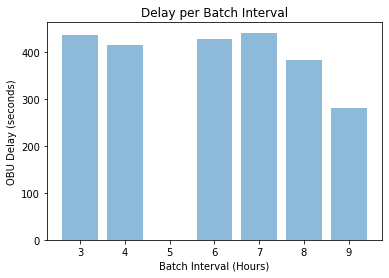

In [9]:
import matplotlib.pyplot as plt
from matplotlib import pyplot

HOURS = [i // 3600 for i in delay_max]
DAYS = [i// (24 * 3600) for i in delay_max]

#new = (pd.to_timedelta(delay_max, unit='d')+pd.to_timedelta(1,unit='s')).astype('timedelta64[m]')

y_pos = np.arange(len(retrieve))
plt.bar(retrieve , delay_max, align='center', alpha=0.5)
#plt.bar(retrieve , HOURS, align='center', alpha=0.5)
#plt.bar(retrieve , DAYS, align='center', alpha=0.5)
plt.ylabel('OBU Delay (seconds)')
plt.xlabel('Batch Interval (Hours)')
plt.title('Delay per Batch Interval')
plt.show()

### Plot messages count per Batch Interval 

Text(0.5, 1.0, 'OBU Count retrieved per Batch Interval')

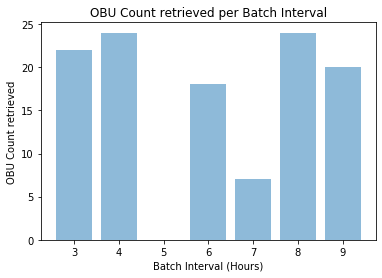

In [10]:
y_pos = np.arange(len(retrieve))
plt.bar(retrieve, number, align='center', alpha=0.5)
plt.ylabel('OBU Count retrieved')
plt.xlabel('Batch Interval (Hours)')
plt.title('OBU Count retrieved per Batch Interval')